In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from transformers import AutoTokenizer
from tqdm import tqdm
import seaborn as sns

# Use retina display for better quality
%config InlineBackend.figure_format = 'retina'

In [3]:
from datasets import Dataset, load_dataset

dataset_name = "HuggingFaceH4/MATH-500"
dataset_split = "test"
dataset = load_dataset(dataset_name, split=dataset_split)
levels = []
gt_answers = [
    row['answer']
    for row in dataset
]
levels = [
    row['level']
    for row in dataset
]

In [4]:
# model_solutions_dir = "/root/tts_and_entropy/model_solutions/dpsk_new_no_sample.json"
model_solutions_dir = "/root/tts_and_entropy/model_solutions/dpsk_new_with_sample_long.json"

MAX_RANGE = 500

model_solutions = []
with open(model_solutions_dir, 'r') as f:
    for line in f:
        if line.strip():
            model_solutions.append(json.loads(line.strip()))
model_solutions = model_solutions[:MAX_RANGE]
reason_lengths = []
reason_number_of_lines = []

model_name = "deepseek-ai/DeepSeek-R1-0528-Qwen3-8B"
tokenizer = AutoTokenizer.from_pretrained(model_name)

for row in model_solutions:
    model_response = (row['response'])
    model_response = model_response.split('</think>')[0]
    # reasoning_line = model_response.split("<think>")[1].split('\n')[1::2]
    reasoning_line = model_response.split("<think>")[1].split('\n\n')
    # Extract reasoning length of each line
    reasoning_length = np.array([
        len(tokenizer(line)['input_ids']) for line in reasoning_line
    ])
    reasoning_length = np.cumsum(reasoning_length)
    reason_lengths.append(reasoning_length)
    reason_number_of_lines.append(len(reasoning_length))


def fine_line_with_max_token(reason_length, max_token=1024):
    """
    Find the line with the maximum token length that is less than or equal to max_token.
    """
    for i, length in enumerate(reason_length):
        if length > max_token:
            return i - 1
    return len(reason_length) - 1
    

In [5]:
def load_log(QID, acc_dir, entropy_dir, entropy_pattern, include_ans=False):
    tmp_dir = acc_dir
    entropy_base_dir = entropy_dir

    ACC = np.load(
        os.path.join(tmp_dir, f'all_accs_{QID}.npy')
    )

    ENTROPY = np.load(
        os.path.join(entropy_base_dir, entropy_pattern.format(QID))
    )

    if include_ans:
        ANS = np.load(
            os.path.join(tmp_dir, f'all_extracted_answers_{QID}.npy')
        )
        ua = []
        for _A in ANS:
            ua.append(len(np.unique(_A)))
        return ACC, ENTROPY, np.array(ua), ANS
    
    return ACC, ENTROPY

acc_dir = '/root/tts_and_entropy/outputs/cached_results_dpsk_long_use_sample'
entropy_dir = '/root/tts_and_entropy/outputs/entropy_log_math'
entropy_template = 'entropy_{}_new_dpsk_new_with_sample_ngram.npy'
entropy_template_with_final_ans = 'entropy_{}_new_dpsk_new_with_sample_ngram_with_final_answer_str.npy'

In [76]:
def plot_q(qid, delta, timescale, normalize, ax=None, entropy_dim=0):
    window_size = 20
    L = load_log_small(qid)
    acc, entropy, no_thinking_entropy = L[0], L[1], L[2]

    # entropy[:, 0] = exponential_moving_average(entropy[:, 0], timescale)


    ema_variance = exponential_moving_variance(entropy[:, entropy_dim], timescale, normalize=normalize)
    # ema_variance = simple_moving_average_variance(entropy[:, 0], timescale)
    # if normalize:
        # ema_variance = (ema_variance ** 0.5) / (ema_variance[int(2 / timescale) - 1] ** 0.5)
    if ax is None:
        fig, ax = plt.subplots(1, 3, figsize=(20, 5))
    if normalize:
        ax[0].plot(entropy[:, entropy_dim] / entropy[:, entropy_dim][:5].mean(), label='Entropy')
    else:
        ax[0].plot(entropy[:, entropy_dim], label='Entropy')
    ax[1].plot(ema_variance)
    ax[1].axvline(4 / timescale, color='red', linestyle='--', label='Minimum stopping point (4 / timescale)')

    early_stop_point = choose_early_stop_point(entropy[:, entropy_dim], timescale, delta, 4 / timescale, normalize=normalize)
    if early_stop_point == -1:
        early_stop_point = len(acc) - 1
    ax[0].axhline(no_thinking_entropy, color='blue', linestyle='--', label='No Thinking Entropy')
    ax[0].axvline(early_stop_point, color='green', linestyle='--', label='Early Stop Point')
    ax[1].axvline(early_stop_point, color='green', linestyle='--', label='Early Stop Point')
    ax[1].axhline(delta, color='orange', linestyle='--', label='Delta Threshold')

    ax[2].plot(acc)
    ax[2].axvline(early_stop_point, color='green', linestyle='--', label='Early Stop Point')

    ax[0].set_title('Entropy')
    ax[1].set_title('EMA estimation of variance')
    ax[2].set_title('Accuracy')
    if entropy_dim == -1:
        ax[0].set_ylim(0, 4)
    else:
        ax[0].set_ylim(0, 2)

    if normalize:
        ax[0].set_ylim(0.5, 1.5)

    for a in ax:
        a.spines['top'].set_visible(False)
        a.spines['right'].set_visible(False)
        a.spines['bottom'].set_visible(False)
        a.legend()
        a.set_xlabel('Number of Lines')

In [6]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


def compute_relative_changes(a):
    """
    Compute the relative changes of a sequence with a moving average window.
    """
    return np.abs(
        (a[1:] - a[:-1])
    )


def get_early_stop_point_posthoc(trace, threshold, min_distance=25, normalize=False):
    trace = trace[1:]
    for i, value in enumerate(trace):
        if i < min_distance:
            continue
        if value < threshold:
            return i
    return None

def exponential_moving_average(data, timescale):
    ema = np.zeros_like(data)
    ema[0] = data[0]
    
    for i in range(1, len(data)):
        ema[i] = timescale * data[i] + (1 - timescale) * ema[i - 1]
    
    return ema

def exponential_moving_variance(data, timescale, ema_0=0.0, normalize=False):
    ema_mean = exponential_moving_average(data, timescale)
    ema_variance = np.zeros_like(data)
    ema_variance[0] = ema_0
    
    for i in range(1, len(data)):
        deviation = data[i] - ema_mean[i]
        ema_variance[i] = timescale * (deviation ** 2) + (1 - timescale) * ema_variance[i - 1]

    return ema_variance

def simple_moving_average_variance(data, window_size=10):
    window = np.ones(window_size) / window_size
    mean_x = np.convolve(data, window, mode='valid')
    mean_x_sq = np.convolve(data**2, window, mode='valid')
    moving_var = mean_x_sq - mean_x**2
    # Pad the beginning of the moving variance to match the length of the original data
    moving_var = np.concatenate((np.zeros(window_size - 1), moving_var))
    return moving_var

def choose_early_stop_point(entropy, timescale, threshold, min_distance=25, ema_0=0.0, min_value_threshold=None, normalize=False):
    # if normalize:
    #     entropy = entropy / entropy[:2].mean()
    ema_variance = exponential_moving_variance(entropy, timescale, ema_0, normalize=normalize)
    if min_distance > len(entropy):
        return -1
    if min_value_threshold is not None:
        min_value_pos = np.argmax(entropy < min_value_threshold)
        min_distance = max(min_value_pos, min_distance)
    exit_idx = get_early_stop_point_posthoc(ema_variance, threshold, min_distance, normalize=normalize)
    return exit_idx if exit_idx is not None else -1

def choose_early_stop_point_moving_window(entropy, window_size, threshold):
    if window_size > len(entropy):
        return -1
    ema_variance = simple_moving_average_variance(entropy, window_size)
    # ema_variance = ema_variance / exponential_moving_average(entropy, timescale)
    exit_idx = get_early_stop_point_posthoc(ema_variance, threshold, window_size, normalize=False)
    return exit_idx if exit_idx is not None else -1

In [7]:
all_accs, all_entropy, all_unique_answers, all_extracted_answers = [], [], [], []
all_entropy_with_final_ans = []
all_entropy_with_final_dpsk_small = []
for qid in tqdm(range(MAX_RANGE)):
    acc, entropy, unique_answers, extracted_answers = load_log(
        qid,
        acc_dir,
        entropy_dir,
        entropy_template,
        include_ans=True
    )
    all_accs.append(acc)
    all_entropy.append(entropy)
    all_unique_answers.append(unique_answers)
    all_extracted_answers.append(extracted_answers)

    _, entropy_2 = load_log(
        qid,
        acc_dir,
        entropy_dir,
        entropy_template_with_final_ans,
        include_ans=False
    )
    all_entropy_with_final_ans.append(entropy_2)

    _, entropy_3 = load_log(
        qid,
        acc_dir,
        entropy_dir,
        'entropy_{}_new_dpsk_new_with_sample_ngram_with_final_answer_str_eatEvaluedBydpsk_small.npy',
        include_ans=False
    )
    all_entropy_with_final_dpsk_small.append(entropy_3)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [36:40<00:00,  4.40s/it]


In [8]:
ZERO_IDX = []
DIFFICULT_IDX = []
VALID_IDX = []
for qid in range(MAX_RANGE):
    token_cost = reason_lengths[qid]
    acc = all_accs[qid]
    if np.mean(acc) == 0:
        ZERO_IDX.append(qid)
    elif acc[-1] == 0:
        DIFFICULT_IDX.append(qid)
        VALID_IDX.append(qid)
    else:
        VALID_IDX.append(qid)

VALID_IDX = np.arange(MAX_RANGE)

In [9]:
# Baselines
# ratios = [
#     0.025 * i for i in range(1, 41)
# ]

max_token_budget = [
    250 * i for i in range(1, 41)
]

accs = []
total_tokens = []
token_usage = []

for budget in tqdm(max_token_budget):
    _accs = []
    _total_tokens = []
    for qid in range(MAX_RANGE):
        if qid not in VALID_IDX:
            continue
        token_cost = reason_lengths[qid]
        acc = all_accs[qid]
        line_number = fine_line_with_max_token(token_cost, max_token=budget)
        _total_tokens.append(token_cost[line_number])
        _accs.append(acc[line_number])
    accs.append(_accs)
    total_tokens.append(np.sum(_total_tokens))
    token_usage.append(_total_tokens)

accs = np.array(accs)
total_tokens = np.array(total_tokens)

results_opt = []
# target_acc = [0.19, 0.29, 0.39, 0.49, 0.59, 0.69, 0.79, 0.89, 0.99, 1.01]
target_acc = np.arange(0.1, 1.01, 0.01)
accs_posthoc_acc = []
total_tokens_posthoc_acc = []
exit_idxes = []
for t in tqdm(target_acc):
    _accs = []
    _total_tokens = []
    for qid in range(MAX_RANGE):
        # if qid not in VALID_IDX:
        #     continue
        token_cost = reason_lengths[qid]
        acc = all_accs[qid]
        exit_idx = np.argmax([acc > t])
        if acc.max() < t:
            exit_idx = -1
        exit_idxes.append(exit_idx)
        _total_tokens.append(token_cost[exit_idx])
        if exit_idx == -1:
            _accs.append(acc.max())
        else:
            _accs.append(acc[exit_idx])
    accs_posthoc_acc.append(_accs)
    total_tokens_posthoc_acc.append(np.sum(_total_tokens))

accs_posthoc_acc = np.array(accs_posthoc_acc)
total_tokens_posthoc_acc = np.array(total_tokens_posthoc_acc)

 53%|███████████████████████████████████████████████████████████████████████████▍                                                                   | 48/91 [00:00<00:00, 225.85it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 224.99it/s]


## Ablation on including final ans string or not

In [10]:
thresholds = np.array([2 ** (-i) for i in range(0, 40)])
accs_entropy_and_token = {}
total_tokens_entropy_and_token = {}
tokens_entropy_and_token = {}
include_final_ans_str_flag = [False, True, 'small', 'mixed']
EIDX = [1]
timescales = [0.05, 0.075, 0.1, 0.15, 0.2, 0.3]

for include_final_ans in include_final_ans_str_flag:
    for timescale in timescales:
        for eidx in EIDX:
            accs_entropy_and_token[(timescale, eidx, include_final_ans)] = []
            total_tokens_entropy_and_token[(timescale, eidx, include_final_ans)] = []
            tokens_entropy_and_token[(timescale, eidx, include_final_ans)] = []
            for t in tqdm(thresholds):
                _accs = []
                _total_tokens = []
                for qid in range(MAX_RANGE):
                    if qid not in VALID_IDX:
                        continue
                    token_cost = reason_lengths[qid]
                    if include_final_ans == 'small':
                        acc, entropy = all_accs[qid], all_entropy_with_final_dpsk_small[qid][:, eidx]
                    elif include_final_ans == 'mixed':
                        acc, entropy_1 = all_accs[qid], all_entropy_with_final_ans[qid][:, eidx]
                        entropy_2 = all_entropy_with_final_dpsk_small[qid][:, eidx]
                        entropy = (entropy_1 + entropy_2) / 2
                    elif include_final_ans == True:
                        acc, entropy = all_accs[qid], all_entropy_with_final_ans[qid][:, eidx]
                    else:
                        acc, entropy = all_accs[qid], all_entropy[qid][:, eidx]
                    exit_idx = fine_line_with_max_token(token_cost, max_token=10000)

                    exit_idx_entropy = choose_early_stop_point(entropy, timescale, t, 40, min_value_threshold=None, normalize=False) 
                    
                    if exit_idx_entropy == -1 or exit_idx_entropy > exit_idx:
                        exit_idx_entropy = exit_idx
                    _total_tokens.append(token_cost[exit_idx_entropy])
                    _accs.append(acc[exit_idx_entropy])
                accs_entropy_and_token[(timescale, eidx, include_final_ans)].append(_accs)
                total_tokens_entropy_and_token[(timescale, eidx, include_final_ans)].append(np.sum(_total_tokens))
                tokens_entropy_and_token[(timescale, eidx, include_final_ans)].append(_total_tokens)

            accs_entropy_and_token[(timescale, eidx, include_final_ans)] = np.array(accs_entropy_and_token[(timescale, eidx, include_final_ans)]).reshape(len(thresholds), len(VALID_IDX))
            total_tokens_entropy_and_token[(timescale, eidx, include_final_ans)] = np.array(total_tokens_entropy_and_token[(timescale, eidx, include_final_ans)]).reshape(len(thresholds))
            tokens_entropy_and_token[(timescale, eidx, include_final_ans)] = np.array(tokens_entropy_and_token[(timescale, eidx, include_final_ans)]).reshape(len(thresholds), len(VALID_IDX))

  2%|███▋                                                                                                                                             | 1/40 [00:00<00:06,  6.34it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.08it/s]


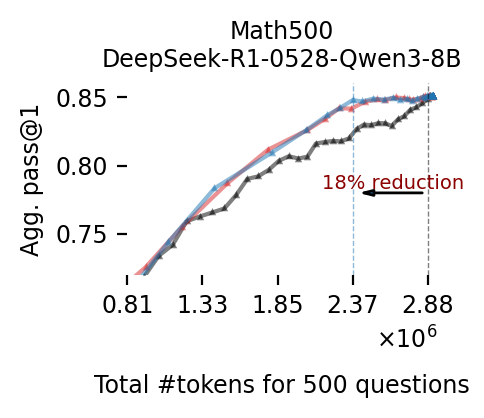

In [ ]:
import matplotlib.ticker as mticker
fig, ax = plt.subplots(figsize=(2.0, 2.0))
from matplotlib import cm
my_colors = cm.tab10([0,1,2,3,4,5])

FONT_SIZE = 8.5

line_config = {
    'marker': '^',
    'markersize': 1, 'linewidth': 1.5,
    'alpha': 0.5
}

ax.plot(total_tokens, accs.mean(1), color='black',
    **line_config)


TT_dpsk_small = total_tokens_entropy_and_token[(0.075, 1, 'small')]
ACC_dpsk_small = accs_entropy_and_token[(0.075, 1, 'small')]


TT_dpsk_new = total_tokens_entropy_and_token[(0.075, 1, 'mixed')]
ACC_dpsk_new = accs_entropy_and_token[(0.075, 1, 'mixed')]

ax.plot(TT_dpsk_small, ACC_dpsk_small.mean(1), c=my_colors[3],
        # linestyle='--',
        **line_config)

ax.plot(TT_dpsk_new, ACC_dpsk_new.mean(1), c=my_colors[0],
        linestyle='-',
        **line_config)

ax.set_xlim(1.0e6, 2.95e6)
ax.set_ylim(0.72, 0.86)

blue_line_idx = TT_dpsk_new[np.argmax(ACC_dpsk_new.mean(1) > 0.847)]
ax.axvline(blue_line_idx, color=my_colors[0], linestyle='--', linewidth=.5, alpha=0.5)

black_line_idx = total_tokens[np.argmax(accs.mean(1) > 0.847)]
ax.axvline(black_line_idx, color='black', linestyle='--', linewidth=.5, alpha=0.5)

class ScalarFormatterForceFormat(mticker.ScalarFormatter):
    def _set_format(self):  # Override function that finds format to use.
        self.format = "%1.2f"  # Give format here

formatter = ScalarFormatterForceFormat(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1,1)) 
ax.xaxis.set_major_formatter(formatter)

ax.get_xaxis().get_offset_text().set_fontsize(FONT_SIZE)
ax.tick_params(axis='both', labelsize=FONT_SIZE)
ax.set_ylabel('Agg. pass@1', fontsize=FONT_SIZE)
ax.set_xlabel('Total #tokens for 500 questions', fontsize=FONT_SIZE, labelpad=20.0)
ax.set_title('Math500\nDeepSeek-R1-0528-Qwen3-8B', fontsize=FONT_SIZE)
ax.set_box_aspect(0.618)

for a in ax.spines.values():
    a.set_visible(False)

# Define the accuracy level for the comparison
y_target = 0.78

import matplotlib.patches as mpatches
arr = mpatches.FancyArrowPatch((black_line_idx, y_target), (blue_line_idx, y_target),
                               arrowstyle='-|>,head_width=.1',
                            # arrowstyle='simple',
                               mutation_scale=9)
ax.add_patch(arr)
ax.annotate("18% reduction",
    (.5, .5), xycoords=arr, ha='center', va='bottom',
    fontsize=7, color='darkred')

# ax.set_xticks([1.0e6, 1.5e6, 2.0e6, blue_line_idx, black_line_idx])
# ax.set_xticks([.9e6, 1.4e6, 1.9e6, blue_line_idx, black_line_idx])

GAP_SIZE = black_line_idx - blue_line_idx
ax.set_xticks([
    blue_line_idx - 3 * GAP_SIZE,
    blue_line_idx - 2 * GAP_SIZE, blue_line_idx - GAP_SIZE,
    blue_line_idx, black_line_idx
])

fig.savefig('/root/figures/math500_qwen3-8b.pdf', bbox_inches='tight')

In [14]:
GAP_SIZE / black_line_idx

np.float64(0.1798437034109269)

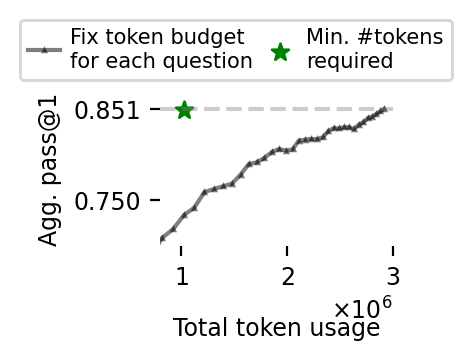

In [59]:
import matplotlib.ticker as mticker
fig, ax = plt.subplots(figsize=(1.5, 1.0))
from matplotlib import cm
my_colors = cm.tab10([0,1,2,3,4,5])

FONT_SIZE = 8.5

line_config = {
    'marker': '^',
    'markersize': 1, 'linewidth': 1.5,
    'alpha': 0.5
}

ax.plot(total_tokens, accs.mean(1), color='black',
        label='Fix token budget\nfor each question',
    **line_config)

ax.set_xlim(.8e6, 3e6)
ax.set_ylim(0.7, .87)

formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1,1)) 
ax.xaxis.set_major_formatter(formatter)
ax.get_xaxis().get_offset_text().set_fontsize(FONT_SIZE)
ax.tick_params(axis='both', labelsize=FONT_SIZE)
ax.set_ylabel('Agg. pass@1', fontsize=FONT_SIZE)
ax.set_xlabel('Total token usage', fontsize=FONT_SIZE, labelpad=10.0)
# ax.set_title('Math500\nDeepSeek-R1-0528-Qwen3-8B', fontsize=FONT_SIZE)

for spine in ax.spines.values():
    spine.set_visible(False)

# ax.spines['top'].set_visible(True)
PHC_IDX = -16
# ax.set_ylim(0.72, 0.852)
ax.set_yticks([0.75, 0.851])
# ax.axhline(accs.mean(1)[-1], linewidth=1.0, color='black', linestyle='-', alpha=1.0)
ax.axhline(0.8514, linewidth=1.5, color='gray', linestyle='--', alpha=0.4)
ax.scatter(total_tokens_posthoc_acc[PHC_IDX], accs_posthoc_acc.mean(-1)[PHC_IDX],
           color='green', marker='*', s=40,
           label='Min. #tokens\nrequired',
           )
# ax.plot(total_tokens_posthoc_acc[:-1], accs_posthoc_acc.mean(-1)[:-1], color='green', marker='*', markersize=4.5, label='Best achievable', alpha=0.5)

ax.legend(
          loc='lower right', fontsize=FONT_SIZE * .89, frameon=True, bbox_to_anchor=(1.3, 1.01), ncol=2,
          handlelength=1.5, handletextpad=0.5, columnspacing=0.5
        )

# ax.axhline(0.9005, color='black', alpha=0.5, linewidth=1.0)


fig.savefig('/root/figures/overthinking_illustration.pdf', bbox_inches='tight')

In [19]:
accs.mean(1)[-1]

np.float64(0.850953125)

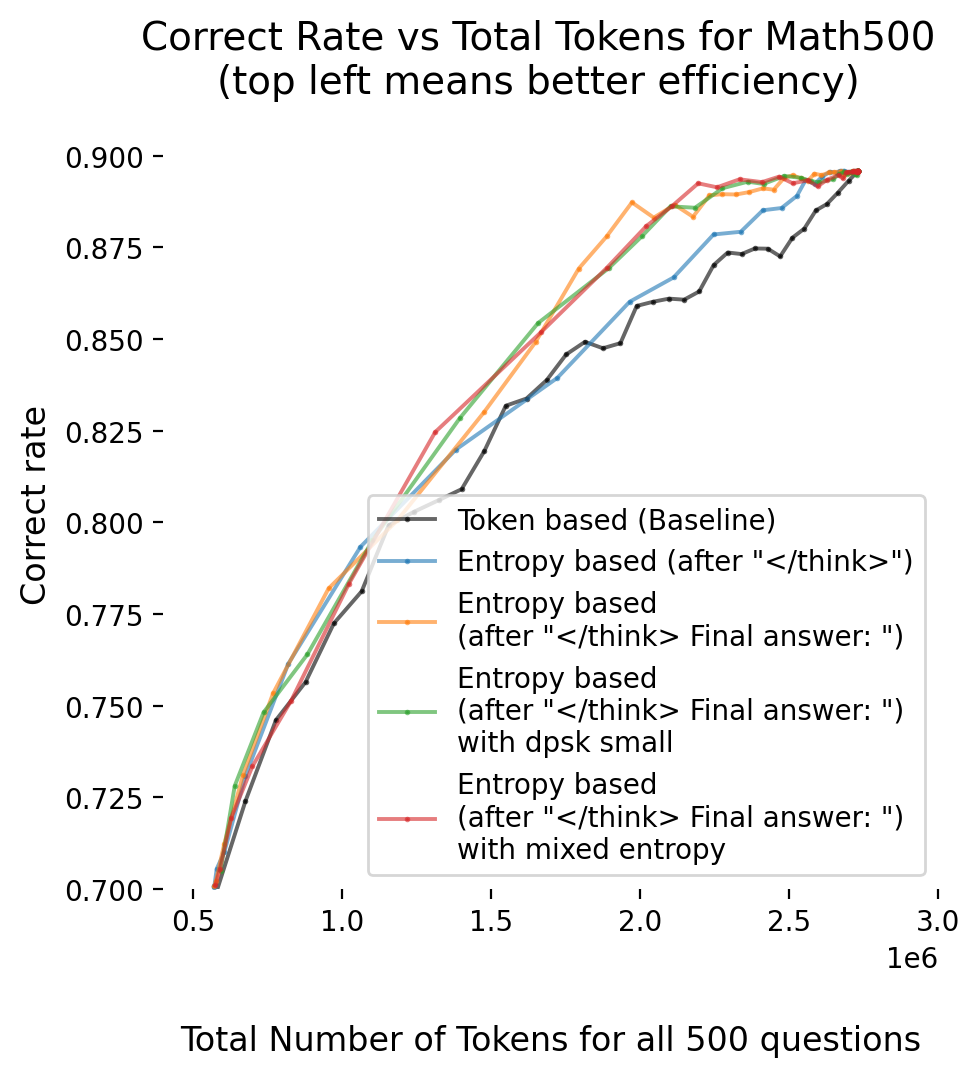

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

TT = total_tokens_entropy_and_token[(0.075, 1, False)]
ACC = accs_entropy_and_token[(0.075, 1, False)]

line_config = {
    'linestyle': '-',
    'marker': 'o',
    'markersize': 1,
    'linewidth': 1.4,
    'alpha': 0.6
}

ax.plot(total_tokens, accs.mean(1), label='Token based (Baseline)', color='black',
    **line_config)
ax.plot(TT, ACC.mean(1), label='Entropy based (after "</think>")',
        **line_config)

TT = total_tokens_entropy_and_token[(0.075, 1, True)]
ACC = accs_entropy_and_token[(0.075, 1, True)]

ax.plot(TT, ACC.mean(1), label='Entropy based\n(after "</think> Final answer: ")',
        **line_config)


TT = total_tokens_entropy_and_token[(0.075, 1, 'small')]
ACC = accs_entropy_and_token[(0.075, 1, 'small')]

ax.plot(TT, ACC.mean(1), label='Entropy based\n(after "</think> Final answer: ")\nwith dpsk small',
        **line_config)


TT = total_tokens_entropy_and_token[(0.075, 1, 'mixed')]
ACC = accs_entropy_and_token[(0.075, 1, 'mixed')]

ax.plot(TT, ACC.mean(1), label='Entropy based\n(after "</think> Final answer: ")\nwith mixed entropy',
        **line_config)

ax.set_xlim(0.4e6, 3.0e6)
ax.set_ylim(0.7, 0.91)

ax.legend()

ax.set_xlabel('\n\nTotal Number of Tokens for all 500 questions', fontsize=12)
ax.set_ylabel('Correct rate', fontsize=12)

fig.suptitle('Correct Rate vs Total Tokens for Math500\n(top left means better efficiency)', fontsize=14)

# Hide frame
for spine in ax.spines.values():
    spine.set_visible(False)

## Ablation on entropy gram

In [ ]:
thresholds = np.array([2 ** (-i) for i in range(0, 40)])
accs_entropy_and_token = {}
total_tokens_entropy_and_token = {}
tokens_entropy_and_token = {}
adaptive_warmup_flag = [False]
include_final_ans_str = [False, True]
EIDX = [1, 2, 3, 4, 5]
timescales = [0.05, 0.075, 0.1, 0.15, 0.2, 0.3]

for adaptive_warmup in adaptive_warmup_flag:
    for timescale in timescales:
        for eidx in EIDX:
            accs_entropy_and_token[(timescale, eidx, adaptive_warmup)] = []
            total_tokens_entropy_and_token[(timescale, eidx, adaptive_warmup)] = []
            tokens_entropy_and_token[(timescale, eidx, adaptive_warmup)] = []
            for t in tqdm(thresholds):
                _accs = []
                _total_tokens = []
                for qid in range(MAX_RANGE):
                    if qid not in VALID_IDX:
                        continue
                    token_cost = reason_lengths[qid]
                    acc, entropy = all_accs[qid], all_entropy[qid][:, eidx]
                    exit_idx = fine_line_with_max_token(token_cost, max_token=10000)

                    if adaptive_warmup:
                        exit_idx_entropy = choose_early_stop_point(entropy, timescale, t, 2 / timescale, min_value_threshold=None, normalize=False) 
                    else:
                        exit_idx_entropy = choose_early_stop_point(entropy, timescale, t, 40, min_value_threshold=None, normalize=False) 
                    
                    if exit_idx_entropy == -1 or exit_idx_entropy > exit_idx:
                        exit_idx_entropy = exit_idx
                    _total_tokens.append(token_cost[exit_idx_entropy])
                    _accs.append(acc[exit_idx_entropy])
                accs_entropy_and_token[(timescale, eidx, adaptive_warmup)].append(_accs)
                total_tokens_entropy_and_token[(timescale, eidx, adaptive_warmup)].append(np.sum(_total_tokens))
                tokens_entropy_and_token[(timescale, eidx, adaptive_warmup)].append(_total_tokens)

            accs_entropy_and_token[(timescale, eidx, adaptive_warmup)] = np.array(accs_entropy_and_token[(timescale, eidx, adaptive_warmup)]).reshape(len(thresholds), len(VALID_IDX))
            total_tokens_entropy_and_token[(timescale, eidx, adaptive_warmup)] = np.array(total_tokens_entropy_and_token[(timescale, eidx, adaptive_warmup)]).reshape(len(thresholds))
            tokens_entropy_and_token[(timescale, eidx, adaptive_warmup)] = np.array(tokens_entropy_and_token[(timescale, eidx, adaptive_warmup)]).reshape(len(thresholds), len(VALID_IDX))
            # tokens_entropy_and_token.append(_total_tokens)
            # accs_entropy_and_token.append(_accs)
            # total_tokens_entropy_and_token.append(np.sum(_total_tokens))

# accs_entropy_and_token = np.array(accs_entropy_and_token).reshape(len(EIDX), len(thresholds),len(VALID_IDX))
# total_tokens_entropy_and_token = np.array(total_tokens_entropy_and_token).reshape(len(EIDX), len(thresholds))
# tokens_entropy_and_token = np.array(tokens_entropy_and_token).reshape(len(EIDX), len(thresholds), len(VALID_IDX))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:08<00:00,  4.48it/s]


# Ablation study on number of grams

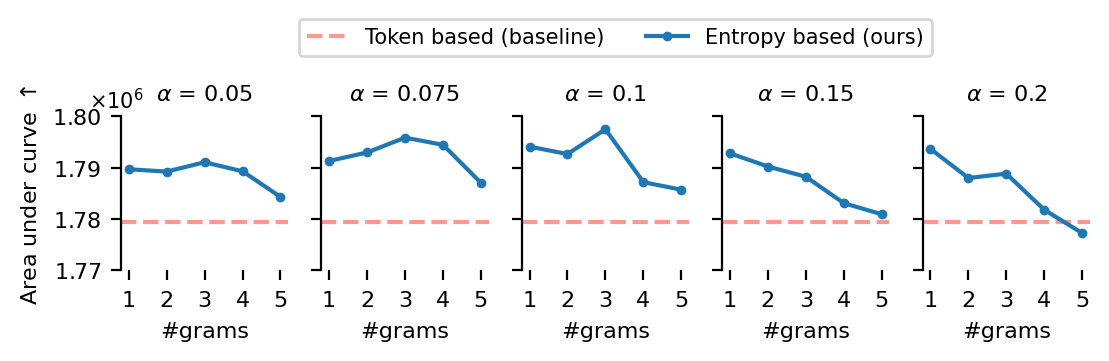

In [ ]:
import matplotlib.ticker as mticker
from sklearn.metrics import auc

line_config = {
    'linewidth': 1.0,
    'alpha': 0.8,
    'marker': 'o',
    'markersize': 0.5,
}

def millions_formatter(x, pos):
    """Formats the number in millions (e.g., 1M, 2.5M)."""
    return f'{x / 1e6:.1f}' + r'$\times 10^6$'

fig, ax = plt.subplots(1, 5, figsize=(6.25, 1.0), sharex='col', sharey='row')
# fig.subplots_adjust(wspace=0.2, hspace=0.4)

FONT_SIZE = 7.5

baseline_auc = auc(
    total_tokens[4:],
    accs.mean(1)[4:],
)

for a in ax.flatten():
    a.tick_params(labelsize=FONT_SIZE + 0.5)
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.spines['bottom'].set_visible(False)
    a.axhline(baseline_auc, color='salmon', linestyle='--', label='Token based (baseline)', alpha=0.8)
    formatter = mticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1,1)) 
    a.yaxis.set_major_formatter(formatter)
    a.get_yaxis().get_offset_text().set_fontsize(FONT_SIZE)
    a.get_yaxis().get_offset_text().set_position((-0.19,0))
    a.set_ylim(1.77 * 10 ** 6, 1.80 * 10 ** 6)

for a in ax[0:1]:
    a.set_ylabel('Area under curve ' + r'$\uparrow$', fontsize=FONT_SIZE + 0.5)

for a in ax:
    a.set_xlabel('#grams', fontsize=FONT_SIZE + 0.5)


for i in range(5):
    ax[i].set_title(r'$\alpha$' f' = {timescales[i]}', fontsize=FONT_SIZE + .5)
    aur_val = []
    for j in range(1, 6, 1):
        aur_val.append(
            auc(
                total_tokens_entropy_and_token[(timescales[i], j, False)],
                accs_entropy_and_token[(timescales[i], j, False)].mean(1)
            )
        )
        # if j == 1:
            # ax[i // 3, i % 3].scatter(1, aur_val[-1], color='blue', label='Unigram entropy (deterministic)', alpha=0.8)
    
    ax[i].plot(
        [1, 2, 3, 4, 5],
        aur_val,
        marker='o',
        markersize=2.5,
        label='Entropy based (ours)',
    )
    ax[i].set_xticks([1, 2, 3, 4, 5])
    

ax[2].legend(
    loc='upper left', fontsize=FONT_SIZE, bbox_to_anchor=(-1.4, 1.7),
    ncols=3
)

fig.savefig('/root/figures/gram_num_ablation.pdf', bbox_inches='tight')


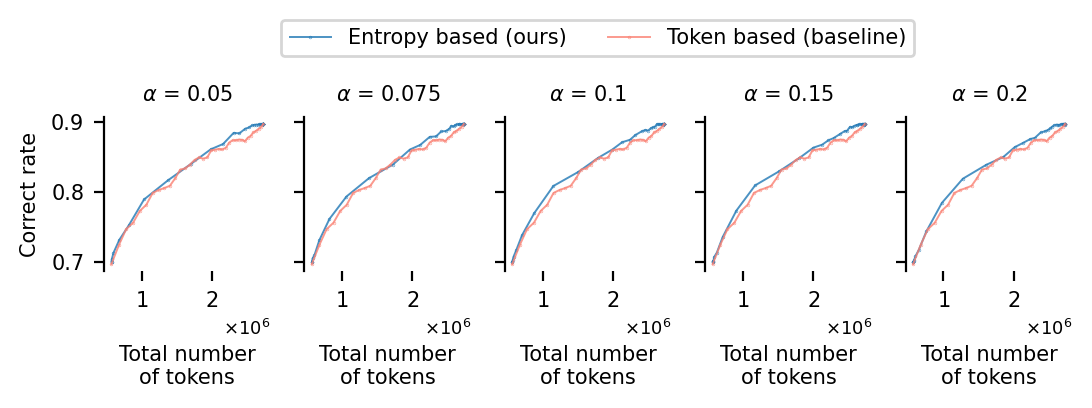

In [ ]:
import matplotlib.ticker as mticker

line_config = {
    'linewidth': 0.7,
    'alpha': 0.8,
    'marker': 'o',
    'markersize': 0.2,
}

def millions_formatter(x, pos):
    """Formats the number in millions (e.g., 1M, 2.5M)."""
    return f'{x / 1e6:.1f}' + r'$\times 10^6$'


fig, ax = plt.subplots(1, 5, figsize=(6.25, 1.0), sharex='col', sharey='row')
# fig.subplots_adjust(wspace=0.2, hspace=0.4)

FONT_SIZE = 7.5

for a in ax.flatten():
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.spines['bottom'].set_visible(False)
    a.tick_params(labelsize=FONT_SIZE)
    formatter = mticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1,1)) 
    a.xaxis.set_major_formatter(formatter)
    a.get_xaxis().get_offset_text().set_fontsize(FONT_SIZE - 1.0)
    # a.get_xaxis().get_offset_text().set_position((0,0))
    # a.xaxis.set_major_formatter(mticker.FuncFormatter(millions_formatter))

for a in ax:
    a.set_xlabel('\nTotal number\nof tokens', fontsize=FONT_SIZE)

ax[0].set_ylabel('Correct rate', fontsize=FONT_SIZE)

# for a in ax[1, :]:
#     a.set_xlabel('Total number of tokens', fontsize=FONT_SIZE)
# for a in ax[:, 0]:
#     a.set_ylabel('Correct rate', fontsize=FONT_SIZE)

for i in range(5):
    ax[i].set_title(r'$\alpha$'+ f' = {timescales[i]}', fontsize=FONT_SIZE)
    # ax[i // 3, i % 3].set_title(r'$\alpha$'+ f' = {timescales[i]}', fontsize=FONT_SIZE)
    ax[i].plot(
        total_tokens_entropy_and_token[(timescales[i], 1, False)],
        accs_entropy_and_token[(timescales[i], 1, False)].mean(1),
        label=f'Entropy based (ours)',
        **line_config,
    )
    ax[i].plot(
        total_tokens[4:],
        accs.mean(1)[4:],
        color='salmon',
        label=f'Token based (baseline)',
        **line_config,
    )

# ax[0, 1].legend(
#     loc='upper left', fontsize=FONT_SIZE, bbox_to_anchor=(-0.8, 1.5),
#     ncols=3
# )

ax[2].legend(
    loc='upper left', fontsize=FONT_SIZE, bbox_to_anchor=(-1.4, 1.7),
    ncols=3
)

fig.savefig('/root/figures/timescale_ablation.pdf', bbox_inches='tight')

# Comparision with baseline

In [ ]:
min_num_ans = np.arange(0, 30, 0.5)
accs_ua = []
total_ua = []
for t in tqdm(min_num_ans):
    _accs = []
    _total_tokens = []
    for qid in range(MAX_RANGE):
        if qid not in VALID_IDX:
            continue
        token_cost = reason_lengths[qid]
        acc, entropy, unique_answers = all_accs[qid], all_entropy[qid][:, eidx], all_unique_answers[qid]
        unique_answers = exponential_moving_average(unique_answers, 0.2)
        exit_idx = fine_line_with_max_token(token_cost, max_token=10000)
        exit_idx_unq_ans = get_early_stop_point_posthoc(unique_answers, t, min_distance=0)
        if exit_idx_unq_ans is None or exit_idx_unq_ans > exit_idx:
            exit_idx_unq_ans = exit_idx
        _total_tokens.append(token_cost[exit_idx_unq_ans])
        _accs.append(acc[exit_idx_unq_ans])
    accs_ua.append(_accs)
    total_ua.append(np.sum(_total_tokens))

accs_ua = np.array(accs_ua)
total_ua = np.array(total_ua)

100%|████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:21<00:00,  2.83it/s]


In [ ]:
all_entropy_var = np.array([e[:, 1].var() for e in all_entropy])
fig, ax = plt.subplots(1, figsize=(3.25, 1.5), sharey='row')

FONT_SIZE = 8

acc_stat = []
tmp_dir = '/root/tts_and_entropy/outputs/cached_results_dpsk_long_use_sample'
bins = {0: [], 1: [], 2: [], 3: []}

for i, QID in enumerate(VALID_IDX):
    if levels[QID] in [1, 2]:
        bins[0].append(i)
    else:
        bins[levels[QID] - 2].append(i)

TT = tokens_entropy_and_token[(0.1, 1, False)]
X = np.array([1, 2, 3, 4])
ax.bar(
    X,
    [all_entropy_var[np.array(bins[i])].mean() for i in range(4)],
    width=0.4,
    alpha=0.9
)
ax.set_ylim(0.04, 0.055)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Difficulty level', fontsize=FONT_SIZE)
ax.set_ylabel('Average EAT variance', fontsize=FONT_SIZE)

ax.tick_params(labelsize=FONT_SIZE)

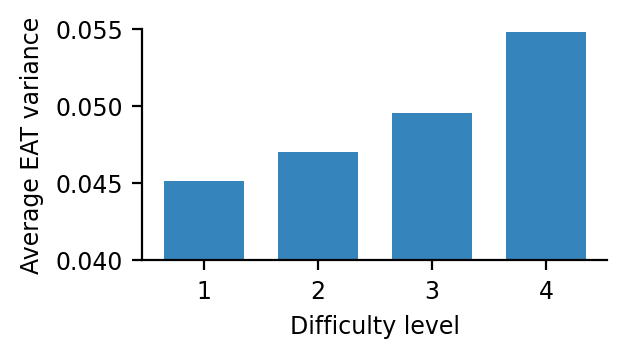

In [311]:
all_entropy_var = np.array([e[:, 1].var() for e in all_entropy])
fig, ax = plt.subplots(1, figsize=(3, 1.5), sharey='row')

FONT_SIZE = 8.5

acc_stat = []
tmp_dir = '/root/tts_and_entropy/outputs/cached_results_dpsk_long_use_sample'
bins = {0: [], 1: [], 2: [], 3: []}

for i, QID in enumerate(VALID_IDX):
    if levels[QID] in [1, 2]:
        bins[0].append(i)
    else:
        bins[levels[QID] - 2].append(i)

TT = tokens_entropy_and_token[(0.1, 1, False)]
X = np.array([1, 2, 3, 4])
ax.bar(
    X,
    [np.mean(all_entropy_var[np.array(bins[i])]) for i in range(4)],
    width=0.7,
    alpha=0.9
)
ax.set_ylim(0.04, 0.055)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Difficulty level', fontsize=FONT_SIZE)
ax.set_ylabel('Average EAT variance', fontsize=FONT_SIZE)

ax.tick_params(labelsize=FONT_SIZE)

fig.savefig('/root/figures/eat_variance_vs_level.pdf', bbox_inches='tight')


Text(0.5, 1.1, 'Distribution of Token Usage for Easy and Hard Questions\nat 90% Accuracy Threshold')

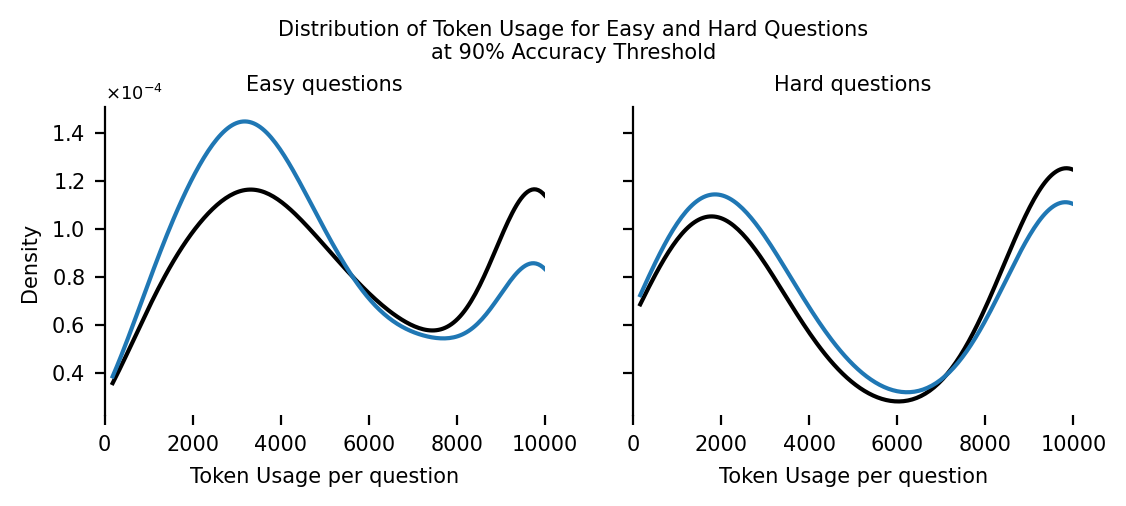

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(6.25, 2.0), sharey='row')

acc_stat = []
tmp_dir = '/root/tts_and_entropy/outputs/cached_results_dpsk_long_use_sample'
for QID in range(MAX_RANGE):
    if QID not in VALID_IDX:
        continue
    ACC = np.load(
        os.path.join(tmp_dir, f'all_accs_{QID}.npy')
    )
    time_to_threshold = np.argmax(ACC > 0.9) / len(ACC)
    if time_to_threshold == 0:
        time_to_threshold = 1.0
    acc_stat.append((np.mean(ACC), np.std(ACC), ACC[-1], time_to_threshold))
acc_stat = np.array(acc_stat)

sns.kdeplot(np.array(token_usage[-1])[acc_stat[:, -1] < 0.5], label='Token based (baseline)', cut=0, c='black', ax=ax[0])
TT = tokens_entropy_and_token[(0.1, 1, False)]
sns.kdeplot(TT[16, :][acc_stat[:, -1] < 0.5], label='Entropy based (ours)', cut=0, ax=ax[0])

sns.kdeplot(np.array(token_usage[-1])[acc_stat[:, -1] > 0.5], label='Token based (baseline)', cut=0, c='black', ax=ax[1])
TT = tokens_entropy_and_token[(0.1, 1, False)]
sns.kdeplot(TT[16, :][acc_stat[:, -1] > 0.5], label='Entropy based (ours)', cut=0, ax=ax[1])

for a in ax:
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.spines['bottom'].set_visible(False)
    a.tick_params(labelsize=FONT_SIZE)
    formatter = mticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1,1)) 
    a.yaxis.set_major_formatter(formatter)
    a.get_yaxis().get_offset_text().set_fontsize(FONT_SIZE - 1.0)
    a.set_xlabel('Token Usage per question', fontsize=FONT_SIZE)
    a.set_ylabel('Density', fontsize=FONT_SIZE)
    a.set_xlim(0, 10000)

ax[0].set_title('Easy questions', fontsize=FONT_SIZE)
ax[1].set_title('Hard questions', fontsize=FONT_SIZE)
fig.suptitle(
    'Distribution of Token Usage for Easy and Hard Questions\nat 90% Accuracy Threshold',
    fontsize=FONT_SIZE,
    y=1.1
)

# plt.gca().spines['right'].set_visible(False)
# plt.gca().spines['top'].set_visible(False)

# plt.xlabel('Token Usage per question')

# plt.title('Distribution of Token Usage Rate for Hard Questions\nat 90% Accuracy Threshold')


# plt.xlabel('Token Usage per question')
# plt.title('Token Usage Distribution (under same accuracy)\n')
# plt.gca().spines['right'].set_visible(False)
# plt.gca().spines['top'].set_visible(False)

# plt.legend()

# Baseline: number of unique answer

In [ ]:
tmp_dir = '/root/tts_and_entropy/outputs/cached_results_dpsk_long_use_sample'
all_anss = []
for id in tqdm(range(MAX_RANGE)):
    ANS = np.load(
        os.path.join(tmp_dir, f'all_extracted_answers_{id}.npy')
    )
    all_anss.append(ANS)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:22<00:00, 21.95it/s]


In [521]:
import pickle
save_dir = '/root/tts_and_entropy/ua_results_cache'
seed = 1233
# with open(os.path.join(save_dir, f'subsampled_unique_counts_all_{seed}.pkl'), 'rb') as f:
#     subsampled_unique_counts_all = pickle.load(f)

with open(os.path.join(save_dir, f'subsampled_unique_counts_all_1.pkl'), 'rb') as f:
    subsampled_unique_counts_all = pickle.load(f)

In [550]:
np.array(subsampled_unique_counts_all[3][0][1]).shape

(66, 64, 16)

In [640]:
accs_ua_all = []
total_ua_all = []

for i in range(len(subsampled_unique_counts_all)):
    min_num_ans = [1, 2, 3, 4]
    accs_ua = []
    total_ua = []
    for t in tqdm(min_num_ans):
        _accs = []
        _total_tokens = []
        for qid in range(MAX_RANGE):
            if qid not in VALID_IDX:
                continue
            token_cost = reason_lengths[qid]
            acc, entropy = all_accs[qid], all_entropy[qid][:, 0]
            unique_answers = subsampled_unique_counts_all[i][qid][0]
            rollout_token_usage = subsampled_unique_counts_all[i][qid][1].sum(-1)
            exit_idx = fine_line_with_max_token(token_cost, max_token=10000)
            for _unique_answers, _rollout_token_usage in zip(unique_answers.T, rollout_token_usage.T):
                exit_idx_unq_ans = np.where(_unique_answers <= t)[0][0] if np.any(_unique_answers <= t) else None
                if exit_idx_unq_ans is None or exit_idx_unq_ans > exit_idx:
                    exit_idx_unq_ans = exit_idx
                _total_tokens.append((token_cost[exit_idx_unq_ans]
                                      ,_rollout_token_usage[10:exit_idx_unq_ans].sum())
                )
                _accs.append(acc[exit_idx_unq_ans])
        accs_ua.append(_accs)
        total_ua.append(_total_tokens)

    accs_ua = np.array(accs_ua)
    total_ua = np.array(total_ua)
    accs_ua_all.append(accs_ua)
    total_ua_all.append(total_ua)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.00it/s]


In [641]:
total_ua_all[i][j].shape

(32000, 2)

In [644]:
total_ua_all[i][j].reshape(-1, 64, 2).sum(0).shape

(64, 2)

In [647]:
mean

[np.float64(8621351.21875),
 np.float64(42146763.921875),
 np.float64(111499806.203125),
 np.float64(251466750.703125)]

In [774]:
T.shape

(64,)

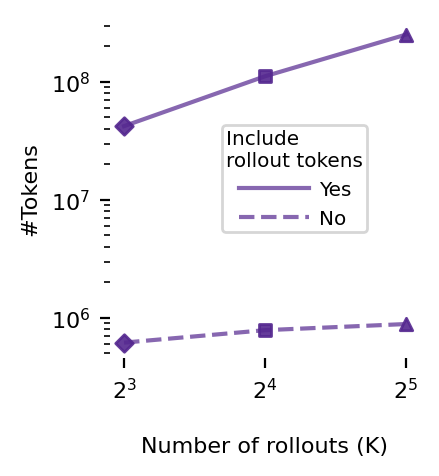

In [783]:
# Plot the *actual* token usage of #UA@K
fig, ax = plt.subplots(figsize=(2.0, 2.2), sharex='col')
j = 0
linestyle=['-', '--']
labels=['Yes', 'No']
markers=['D', 's', '^']
for ii, IDX in enumerate([[0, 1], [0]]):
    FSIZE = 8
    mean, std = [], []
    for i in [2, 3, 4]:
        T = total_ua_all[i][j].reshape(-1, 64, 2).sum(0)[:, IDX].sum(-1)
        mean.append(T.mean())
        std.append(T.std())
        ax.scatter(
            2 ** (i + 1), T.mean(), alpha=0.9, color='#54278f',
            marker=markers[i - 2], s=20)
    ax.plot(
        2 ** (np.arange(1, 4) + 2), mean, alpha=0.7, color='#54278f',
        # marker='o', 
        markersize=3, linewidth=1.5, linestyle=linestyle[ii],
        label=f'{labels[ii]}'
    )
    # ax.fill_between(2 ** (np.arange(4) + 2), np.array(mean) - np.array(std), np.array(mean) + np.array(std), color='#54278f', alpha=0.3)



ax.set_xticks(2 ** (np.arange(1, 4) + 2))
ax.set_xscale('log', base=2)
# ax.set_xticklabels([f'UA@{i}' for i in range(1, 4)])
ax.set_ylabel('#Tokens', fontsize=FSIZE)
ax.set_xlabel('Number of rollouts (K)', fontsize=FSIZE, labelpad=12.0)
ax.legend(
    fontsize=FSIZE * .9, loc='upper left', frameon=True, bbox_to_anchor=(.35, .7),
    title_fontsize=FSIZE * .9, title='Include\nrollout tokens', # make line longer, 
    handlelength=3.5, handletextpad=0.5, borderpad=0.2, borderaxespad=0.2
)

formatter = mtick.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1,1)) 
ax.yaxis.set_major_formatter(formatter)
ax.get_yaxis().get_offset_text().set_fontsize(FSIZE)
ax.tick_params(labelsize=FSIZE)
ax.set_yscale('log')
# ax.set_box_aspect(0.8)

for a in ax.spines.values():
    a.set_visible(False)

fig.savefig(
    '/root/figures/rollout_token_usage.pdf', bbox_inches='tight'    
)

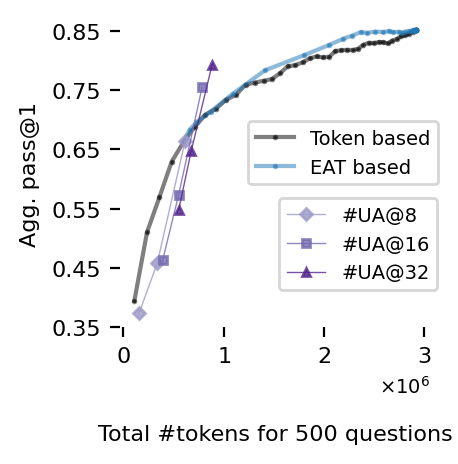

In [871]:
line_config = {
    'linewidth': 1.5,
    'alpha': 0.5,
    'marker': 'o',
    'markersize': 1.0,
}

fig, ax = plt.subplots(1, 1, figsize=(2.0, 2.0))

import matplotlib.ticker as mtick
 # If you would like 1x10-5, set it as False if like 1e10-5
formatter = mtick.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
# I don't know what (-1, 1) is for :D
formatter.set_powerlimits((-1,1)) 
ax.xaxis.set_major_formatter(formatter)
ax.get_xaxis().get_offset_text().set_fontsize(7)
ax.tick_params(labelsize=8)

ax2 = ax.twinx()
colors = ['#9e9ac8','#756bb1','#54278f']
markers=['D', 's', '^']
for i in [2, 3, 4]:
    _A, _T = [], []
    for j in [0, 1, 2]:
        A = accs_ua_all[i][j].reshape(-1, 64).mean(0)
        T = total_ua_all[i][j].reshape(-1, 64, 2)[..., 0].sum(0)
        _A.append(A.mean())
        _T.append(T.mean())
    ax2.plot(_T, _A, 
            c=colors[i - 2],
            label=f'#UA@{2**(i+1)}',
            linewidth=0.5,
            alpha=0.8,
            marker=markers[i - 2],
            markersize=3.0,
            )

TT = total_tokens_entropy_and_token[(0.075, 1, 'mixed')]
ACC = accs_entropy_and_token[(0.075, 1, 'mixed')]

ax.plot(total_tokens, accs.mean(1), label='Token based', color='black', **line_config)
ax.plot(TT, ACC.mean(1), label='EAT based',**line_config)
# ax.legend(fontsize=7, loc='upper left', bbox_to_anchor=(0.5, 0.7), ncol=1,
#           markerscale=5)


# ax.legend(fontsize=13, markerscale=5)
# ax.set_xlabel('\n\nTotal Number of Tokens for all 500 questions', fontsize=8)
ax.set_xlabel('\n\nTotal #tokens for 500 questions', fontsize=8)
ax.set_ylabel('Agg. pass@1', fontsize=8)

# Hide frame
for spine in ax.spines.values():
    spine.set_visible(False)

for spine in ax2.spines.values():
    spine.set_visible(False)
ax2.get_yaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
ax2.legend(
    fontsize=7, loc='upper left', bbox_to_anchor=(0.48, 0.45), ncol=1,
)

ax.legend(
    fontsize=7, loc='upper left', bbox_to_anchor=(0.38, 0.7), ncol=1,
)

for a in [ax, ax2]:
    a.set_ylim(0.35, 0.87)
    a.set_yticks([0.35, 0.45, 0.55, 0.65, 0.75, 0.85])

# ax.set_box_aspect(0.8)
# ax2.set_box_aspect(0.8)


fig.savefig('/root/figures/ua_ablation.pdf', bbox_inches='tight')